In [96]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import argparse
import time, sys
import re
import lexica
import importlib
importlib.reload(lexica)
import pickle
from transformers import XLMRobertaTokenizer


lexica_dict = lexica.generate_lexica()


In [97]:
keys_en = lexica_dict["English"].keys()
keys_zh = lexica_dict["Japanese"].keys()

#find which keys are in both
keys_both = []
for key in keys_en:
    if key in keys_zh:
        keys_both.append(key)

# find which keys are only in one
keys_en_only = []
for key in keys_en:
    if key not in keys_zh:
        keys_en_only.append(key)

keys_zh_only = []
for key in keys_zh:
    if key not in keys_en:
        keys_zh_only.append(key)

# print results
print("Keys in both:")
print(keys_both)
print("Keys only in English:")
print(keys_en_only)
print("Keys only in Chinese:")
print(keys_zh_only)

Keys in both:
['gratitude', 'deference', 'greeting', 'has_positive', 'has_negative', 'apologetic', 'please', 'indirect_btw', 'direct_question', 'subjunctive', 'indicative', 'first_person_plural', 'first_person_singular', 'second_person', 'hedge', 'factuality', 'emergency', 'ingroup_ident', 'praise', 'promise', 'together']
Keys only in English:
['please_start', 'direct_start', 'first_person_start', 'second_person_start']
Keys only in Chinese:
['you_direct', 'you_honorific', 'taboo']


In [98]:
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

def read_shap_values_pickle(file_path):
    with open(file_path, 'rb') as file:
        shap_values = pickle.load(file)
    return shap_values

def get_word_level_shapley_values(shap_filepath, tokenize, language):
    shap_pickle = read_shap_values_pickle(shap_filepath)
    print("loaded")
    word_level_shapley_values = []
    shap_data = shap_pickle.data
    shap_values = shap_pickle.values
    shap_base = shap_pickle.base_values
    for idx in tqdm(range(len(shap_data))):
        tokens = shap_data[idx]
        values = shap_values[idx]
        base = shap_base[idx]

        #divide base amongst all tokens
        base_add = base/len(tokens)
        values = [v + base_add for v in values]
        
        utterance_string = tokenizer.convert_tokens_to_string(tokens)
        #separate into word tokens based on language
        if(language=="English" or language=="Spanish"):
            word_tokens = re.findall(r"[\w']+|[.,!?;]", utterance_string)
        else:
            word_tokens = re.findall(r"[\w']+|[，。！？；]", utterance_string)

        word_values = []
        i = 0
        for word in word_tokens:
            num_subtokens = len(tokenizer.tokenize(word))
            word_values.append(np.sum(values[i:i+num_subtokens]))
            i += num_subtokens
        word_level_shapley_values.append((word_tokens, word_values))
    return word_level_shapley_values

def detect_politeness_strategy(sentences, politeness_strategies, language="English", shap_object=None, tokenizer=None):
    sentence_strategies = []
    for sentence in sentences:
        strategies = {}
        if(language=="English" or language=="Spanish"):
            for strategy, expressions in politeness_strategies.items():
                for expression in expressions:
                    try:
                        if re.search(expression, sentence, re.IGNORECASE):
                            #set strategy to part of sentence that matches expression
                            strategies[strategy] = re.findall(expression, sentence, re.IGNORECASE)
                    except:
                        print("error with %s in %s" % (expression, sentence))
        else:
            for strategy, pattern in politeness_strategies.items():
                if pattern.search(sentence):
                    strategies[strategy] = pattern.findall(sentence)
        sentence_strategies.append(strategies)
    return sentence_strategies

def get_all_strategies(language, detected_strategies, shapley_values):    
    strategy_importances = { x:0 for x in lexica_dict[language].keys()} 
    strategy_counts = { x:0 for x in lexica_dict[language].keys()} 
    for i, sentence_strategies in enumerate(detected_strategies):
        for strat, matches in sentence_strategies.items():
            for match in matches:
                try:
                    match_parts = match.split()
                except:
                    match_parts_temp = [x for x in match if x != ""]
                    match_parts = []
                    for m in match_parts_temp:
                        m_parts = m.split()
                        for m_part in m_parts:
                            match_parts.append(m_part)
                match_parts = np.unique(match_parts)
                for part in match_parts:
                    try:
                        # find part in shapley values
                        idxs = [i for i, x in enumerate(shapley_values[i][0]) if x == part]
                        if(len(idxs) == 0):
                            idxs = [i for i, x in enumerate(shapley_values[i][0]) if part in x]
                        if(len(idxs) == 0):
                            print("no idxs for %s with %s in %s" % (strat, part, shapley_values[i][0]))
                    except:
                        print("error in %s with %s in %s" % (strat, part, shapley_values[i][0]))
                    for idx in idxs:
                        if(language=="English" or language=="Spanish"):
                            strategy_importances[strat] += shapley_values[i][1][idx]
                            strategy_counts[strat] += 1
                        else:
                            component = (shapley_values[i][1][idx]/len(shapley_values[i][0][idx]))*len(part)
                            strategy_importances[strat] += component
                            strategy_counts[strat] += 1
                            # print(strategy_importances[strat])
    return strategy_importances, strategy_counts

def process_strategy_results(strategies):
    values = strategies[0]
    counts = strategies[1]
    for key in values.keys():
        if(counts[key] != 0):
            values[key] = values[key]/counts[key]
    return values

In [99]:
prefix = "shapley/xlm_shap_values/"

In [100]:
shap_en = get_word_level_shapley_values(prefix+"english.p", tokenizer, "English")
utterances_en = [" ".join(x[0]) for x in shap_en]
detected_strategies_en = detect_politeness_strategy(utterances_en, lexica_dict["English"], language="English")

strategies_english = get_all_strategies("English", detected_strategies_en, shap_en)
strategies_english = process_strategy_results(strategies_english)

loaded


 26%|██▌       | 1469/5700 [00:06<00:15, 270.18it/s]

In [ ]:
shap_es = get_word_level_shapley_values(prefix+'spanish.p', tokenizer, "Spanish")
utterances_es = [" ".join(x[0]) for x in shap_es]
detected_strategies_es = detect_politeness_strategy(utterances_es, lexica_dict["Spanish"], language="Spanish")

strategies_spanish = get_all_strategies("Spanish", detected_strategies_es, shap_es)
print(strategies_spanish)
strategies_spanish = process_strategy_results(strategies_spanish)

loaded


100%|██████████| 5699/5699 [00:21<00:00, 269.53it/s]


({'gratitude': 6.267512625540899, 'deference': 13.185203555793695, 'greeting': 8.558454410273347, 'has_positive': 0, 'has_negative': 0, 'apologetic': 2.689716329676336, 'please': 1.7375305294398782, 'please_start': 1.7108282691396794, 'indirect_btw': 2.6715559268059814, 'direct_question': 31.33135409909722, 'direct_start': 1.6443182177068423, 'subjunctive': 5.568724562828909, 'indicative': 17.38057786656661, 'first_person_start': 7.762036915776546, 'first_person_plural': 5.485063820024498, 'first_person_singular': 74.1406423959208, 'second_person': 54.560015454408365, 'second_person_start': 0.617815064182605, 'hedge': 121.34461389544605, 'factuality': 27.76615280416103, 'emergency': 1.5941859073017515, 'ingroup_ident': 1.1816963755877845, 'praise': 8.556123120460835, 'promise': 5.49495784826137, 'together': 0.28744901699422387}, {'gratitude': 169, 'deference': 434, 'greeting': 272, 'has_positive': 0, 'has_negative': 0, 'apologetic': 65, 'please': 64, 'please_start': 54, 'indirect_btw':

In [ ]:
shap_zh = get_word_level_shapley_values(prefix+'chinese.p', tokenizer, "Chinese")
utterances_zh = [" ".join(x[0]) for x in shap_zh]
detected_strategies_zh = detect_politeness_strategy(utterances_zh, lexica_dict["Chinese"], language="Chinese")

strategies_chinese = get_all_strategies("Chinese", detected_strategies_zh, shap_zh)
strategies_chinese = process_strategy_results(strategies_chinese)

loaded


100%|██████████| 5700/5700 [00:05<00:00, 992.34it/s] 


In [ ]:
shap_ja = get_word_level_shapley_values(prefix+'japanese.p', tokenizer, "Japanese")
utterances = [" ".join(x[0]) for x in shap_ja]
detected_strategies = detect_politeness_strategy(utterances, lexica_dict["Japanese"], language="Japanese")

strategies_japanese = get_all_strategies("Japanese", detected_strategies, shap_ja)
print(strategies_japanese)
strategies_japanese = process_strategy_results(strategies_japanese)

loaded


100%|██████████| 5699/5699 [00:04<00:00, 1419.95it/s]


({'gratitude': 104.18534170396653, 'deference': 5.40940083219354, 'greeting': 44.85032482384017, 'has_positive': 0, 'has_negative': 0, 'apologetic': 110.93945822341767, 'please': 22.79092893467149, 'indirect_btw': 8.218468894648959, 'direct_question': 0.09434803102722583, 'subjunctive': 0, 'indicative': 45.50684353191477, 'first_person_plural': 0.20677328695403663, 'first_person_singular': 40.791371545471414, 'second_person': 7.791572492198716, 'hedge': 57.30540626993729, 'factuality': 7.258653988942386, 'emergency': 2.4483721199101645, 'ingroup_ident': 0.25240845510757715, 'praise': 46.327264006457526, 'promise': 15.394434860543447, 'together': 0.16582358521807242, 'you_direct': 8.309269188219897, 'you_honorific': 0.3067536375664258, 'taboo': 3.69899810342791}, {'gratitude': 1240, 'deference': 152, 'greeting': 115, 'has_positive': 0, 'has_negative': 0, 'apologetic': 186, 'please': 214, 'indirect_btw': 72, 'direct_question': 3, 'subjunctive': 0, 'indicative': 236, 'first_person_plural'

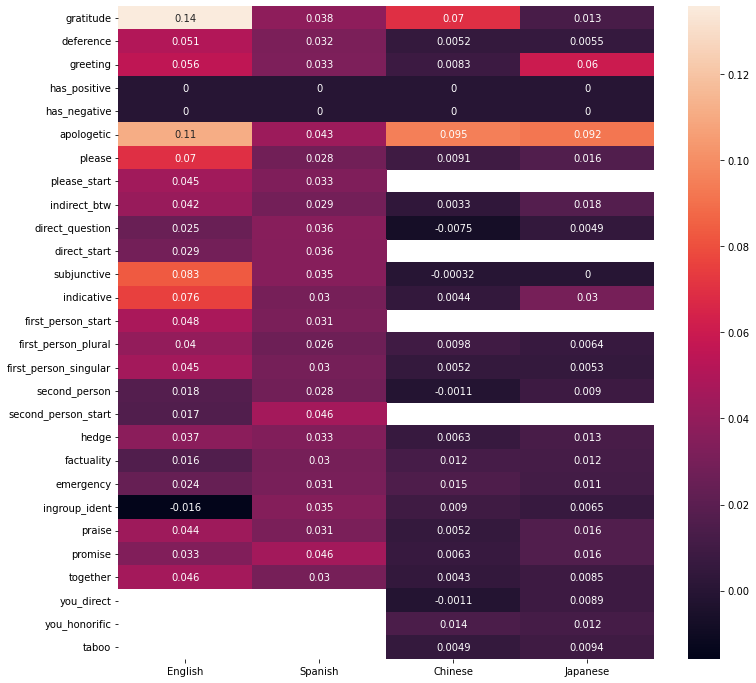

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


#get average of sentence lengths for all languages
en_lengths_avg = np.average([len(x[0]) for x in shap_en])
es_lengths_avg = np.average([len(x[0]) for x in shap_es])
zh_lengths_avg = np.average([len(x[0]) for x in shap_zh])
ja_lengths_avg = np.average([len(x[0]) for x in shap_ja])

en_values = strategies_english.copy()
es_values = strategies_spanish.copy()
zh_values = strategies_chinese.copy()
ja_values = strategies_japanese.copy()

#multiply values in dicts by avg
for key in es_values.keys():
    es_values[key] *= (es_lengths_avg/en_lengths_avg)
for key in zh_values.keys():
    zh_values[key] *= (zh_lengths_avg/en_lengths_avg)
for key in ja_values.keys():
    ja_values[key] *= (ja_lengths_avg/en_lengths_avg)

df = pd.DataFrame([en_values, es_values, zh_values, ja_values], 
                   index=["English", "Spanish", "Chinese", "Japanese"])

plt.figure(figsize=(12, 12))
sns.heatmap(df.T, annot=True)
plt.show()


In [ ]:
#get average of shap values for all languages
shap_en_avg = np.average([np.sum(x[1]) for x in shap_en])
shap_es_avg = np.average([np.sum(x[1]) for x in shap_es])
shap_zh_avg = np.average([np.sum(x[1]) for x in shap_zh])
shap_ja_avg = np.average([np.sum(x[1]) for x in shap_ja])

#print all
print("English: " + str(shap_en_avg))
print("Spanish: " + str(shap_es_avg))
print("Chinese: " + str(shap_zh_avg))
print("Japanese: " + str(shap_ja_avg))

#get average of sentence lengths for all languages
en_lengths_avg = np.average([len(x[0]) for x in shap_en])
es_lengths_avg = np.average([len(x[0]) for x in shap_es])
zh_lengths_avg = np.average([len(x[0]) for x in shap_zh])
ja_lengths_avg = np.average([len(x[0]) for x in shap_ja])

#print all
print("English: " + str(en_lengths_avg))
print("Spanish: " + str(es_lengths_avg))
print("Chinese: " + str(zh_lengths_avg))
print("Japanese: " + str(ja_lengths_avg))

English: 2.109878363563836
Spanish: 1.895917066219758
Chinese: 1.7795849126190875
Japanese: 2.466525788456861
English: 50.10614035087719
Spanish: 51.99964906123881
Chinese: 12.243684210526316
Japanese: 7.729777153886647


In [ ]:
#get counts of all strategies across languages
en_counts = get_all_strategies("English", detected_strategies_en, shap_en)[1]
es_counts = get_all_strategies("Spanish", detected_strategies_es, shap_es)[1]
zh_counts = get_all_strategies("Chinese", detected_strategies_zh, shap_zh)[1]
ja_counts = get_all_strategies("Japanese", detected_strategies, shap_ja)[1]

# #print all
print("English: " + str(en_counts))
print("Spanish: " + str(es_counts))
print("Chinese: " + str(zh_counts))
print("Japanese: " + str(ja_counts))

English: {'gratitude': 219, 'deference': 487, 'greeting': 217, 'has_positive': 0, 'has_negative': 0, 'apologetic': 94, 'please': 70, 'please_start': 35, 'indirect_btw': 84, 'direct_question': 2649, 'direct_start': 67, 'subjunctive': 41, 'indicative': 46, 'first_person_start': 2082, 'first_person_plural': 1080, 'first_person_singular': 11598, 'second_person': 2540, 'second_person_start': 107, 'hedge': 3643, 'factuality': 697, 'emergency': 91, 'ingroup_ident': 28, 'praise': 399, 'promise': 426, 'together': 42}
Spanish: {'gratitude': 169, 'deference': 434, 'greeting': 272, 'has_positive': 0, 'has_negative': 0, 'apologetic': 65, 'please': 64, 'please_start': 54, 'indirect_btw': 97, 'direct_question': 903, 'direct_start': 48, 'subjunctive': 164, 'indicative': 599, 'first_person_start': 258, 'first_person_plural': 217, 'first_person_singular': 2598, 'second_person': 2006, 'second_person_start': 14, 'hedge': 3781, 'factuality': 952, 'emergency': 54, 'ingroup_ident': 35, 'praise': 283, 'promis

In [ ]:
thresh = 10
#print counts of categories that are < 10
print("English: " + str({k: v for k, v in en_counts.items() if v < thresh}))
print("Spanish: " + str({k: v for k, v in es_counts.items() if v < thresh}))
print("Chinese: " + str({k: v for k, v in zh_counts.items() if v < thresh}))
print("Japanese: " + str({k: v for k, v in ja_counts.items() if v < thresh}))

English: {'has_positive': 0, 'has_negative': 0}
Spanish: {'has_positive': 0, 'has_negative': 0}
Chinese: {'has_positive': 0, 'has_negative': 0, 'subjunctive': 1}
Japanese: {'has_positive': 0, 'has_negative': 0, 'direct_question': 3, 'subjunctive': 0, 'first_person_plural': 5, 'ingroup_ident': 6, 'together': 3, 'you_honorific': 4}


In [ ]:
English: {'has_positive': 0, 'has_negative': 0, 'please_start': 35, 'subjunctive': 41, 'indicative': 46, 'ingroup_ident': 28, 'together': 42}
Spanish: {'has_positive': 0, 'has_negative': 0, 'direct_start': 48, 'second_person_start': 14, 'ingroup_ident': 35, 'together': 10}
Chinese: {'greeting': 2, 'has_positive': 0, 'has_negative': 0, 'indirect_btw': 17, 'direct_question': 17, 'subjunctive': 1, 'emergency': 16, 'ingroup_ident': 11, 'together': 44}
Japanese: {'gratitude': 20, 'has_positive': 0, 'has_negative': 0, 'direct_question': 2, 'subjunctive': 0, 'indicative': 47, 'first_person_plural': 0, 'emergency': 29, 'ingroup_ident': 5, 'together': 3}